### Preprocessing

Pupil Data

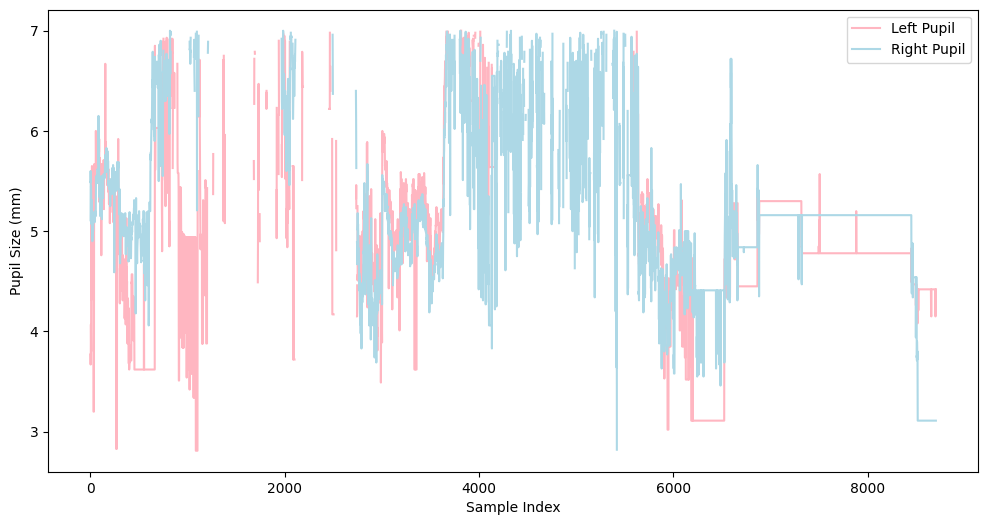

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('PupilData/PupilData_243383_corrupted.csv', header=0, names=['Timestamp', 'Scene', 'LeftPupil(mm)', 'RightPupil(mm)', 'LeftValid', 'RightValid'])

df.head()
df['LeftPupil(mm)'] = pd.to_numeric(df['LeftPupil(mm)'], errors='coerce')
df['RightPupil(mm)'] = pd.to_numeric(df['RightPupil(mm)'], errors='coerce')

plt.figure(figsize=(12, 6))
plt.plot(df['LeftPupil(mm)'], label='Left Pupil', color='lightpink')
plt.plot(df['RightPupil(mm)'], label='Right Pupil', color='lightblue')

for i in range(1, len(df)):
    if (df['Scene'].iloc[i-1] == 'AvatarSceneHappy' or df['Scene'].iloc[i-1] == 'AvatarSceneNeutral') and df['Scene'].iloc[i] == 'BaselineScene':
        plt.axvline(x=i, color='r', linestyle='--', alpha=0.5)

plt.xlabel('Sample Index')
plt.ylabel('Pupil Size (mm)')
plt.legend()
plt.show()

In [71]:
import pandas as pd
import numpy as np
import os
from glob import glob

data_folder = 'PupilData/'

summary = []

for file_path in glob(os.path.join(data_folder, 'PupilData_*.csv')):
    if '_corrupted' in file_path:
        continue

    try:
        df = pd.read_csv(file_path)

        df['LeftPupil(mm)'] = pd.to_numeric(df['LeftPupil(mm)'], errors='coerce')
        df['RightPupil(mm)'] = pd.to_numeric(df['RightPupil(mm)'], errors='coerce')
        df['LeftValid'] = df['LeftValid'].astype(str).str.lower().map({'true': True, 'false': False})
        df['RightValid'] = df['RightValid'].astype(str).str.lower().map({'true': True, 'false': False})

        participant_id = os.path.basename(file_path).split('_')[1].replace('.csv', '')

        left_valid_rate = df['LeftValid'].mean() * 100
        right_valid_rate = df['RightValid'].mean() * 100

        valid_data = df[df['LeftValid'] & df['RightValid']].copy()
        valid_data = valid_data.replace(0, np.nan).dropna(subset=['LeftPupil(mm)', 'RightPupil(mm)'])

        correlation = valid_data['LeftPupil(mm)'].corr(valid_data['RightPupil(mm)'])

        summary.append({
            'Participant': participant_id,
            'Left Validity (%)': round(left_valid_rate, 2),
            'Right Validity (%)': round(right_valid_rate, 2),
            'Left-Right Correlation': round(correlation, 2) if not np.isnan(correlation) else None
        })
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

summary_df = pd.DataFrame(summary)
summary_df.to_csv('summary_results.csv')

In [ ]:
import matplotlib.pyplot as plt

participants = summary_df.index.astype(str)

fig, axs = plt.subplots(2, 1, figsize=(14, 14), gridspec_kw={'hspace': 0.4})

x = range(len(participants))
bar_width = 0.35

axs[0].bar(x, summary_df['Left Validity (%)'], width=bar_width, label='Left Validity', color='skyblue')
axs[0].bar([i + bar_width for i in x], summary_df['Right Validity (%)'], width=bar_width, label='Right Validity', color='lightgreen')
axs[0].axhline(95, color='red', linestyle='--', label='95% Threshold')
axs[0].set_title('Validity of Pupil Data by Participant')
axs[0].set_ylabel('Validity (%)')
axs[0].set_xticks([i + bar_width / 2 for i in x])
axs[0].set_xticklabels(participants, rotation=90)
axs[0].legend()

axs[1].bar(participants, summary_df['Left-Right Correlation'], color='coral')
axs[1].axhline(0.5, color='red', linestyle='--', label='Threshold (r=0.5)')
axs[1].set_title('Correlation Between Left and Right Pupil Size')
axs[1].set_ylabel('Pearson Correlation (r)')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, savgol_filter
import matplotlib.pyplot as plt
import os
import pandas as pd

def preprocess_pupils(file_path, eyeData, surrounding_ms=200, fs=10, plot=True, eye='Left'):
    # === Load and basic filtering ===
    if eyeData is None:
        df = pd.read_csv(file_path)
        df[f'{eye}Valid'] = df[f'{eye}Valid'].astype(str).str.lower() == 'true'
        df = df[df[f'{eye}Valid']].copy()
        df[f'{eye}Pupil(mm)'] = pd.to_numeric(df[f'{eye}Pupil(mm)'], errors='coerce')
        df_raw = df.copy()
    else:
        df = eyeData

    # === Implausible values removed ===
    df.loc[(df[f'{eye}Pupil(mm)'] < 1.5) | (df[f'{eye}Pupil(mm)'] > 7.0), f'{eye}Pupil(mm)'] = np.nan

    # === Blink-surrounding trimming ===
    surrounding = int((surrounding_ms / 1000) * fs)
    blink_indices = df[df[f'{eye}Pupil(mm)'].isna()].index
    for i in blink_indices:
        df.loc[max(i - surrounding, 0):min(i + surrounding, len(df) - 1), f'{eye}Pupil(mm)'] = np.nan

    # === Remove spikes & high acceleration ===
    diff = df[f'{eye}Pupil(mm)'].diff().abs()
    df.loc[diff > 0.5, f'{eye}Pupil(mm)'] = np.nan

    accel = None
    if not df.empty:
        accel = df[f'{eye}Pupil(mm)'].diff().diff().abs()
    
    df.loc[accel > 0.3, f'{eye}Pupil(mm)'] = np.nan

    # === Interpolation ===
    df[f'{eye}Pupil(mm)'] = df[f'{eye}Pupil(mm)'].interpolate(method='spline', order=2, limit_direction='both')

    # === Savitzky-Golay smoothing ===
    df[f'{eye}Pupil(mm)'] = savgol_filter(df[f'{eye}Pupil(mm)'].fillna(method='pad'), window_length=5, polyorder=2)

    # === Butterworth lowpass filtering (balanced) ===
    def butter_lowpass_filter(data, cutoff=0.6, fs=10, order=2):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    df[f'{eye}PupilFiltered(mm)'] = butter_lowpass_filter(df[f'{eye}Pupil(mm)'], cutoff=0.6, fs=fs)

    if plot:
        plt.figure(figsize=(16, 6))
        plt.plot(df_raw[f'{eye}Pupil(mm)'], label=f'{eye} Eye (Filtered)', color='blue')
        plt.plot(df[f'{eye}PupilFiltered(mm)'], label=f'{eye} Eye (Filtered)', color='orange')
        plt.title(f'{eye} Eye Pupil Size – Filtered (10 Hz, Balanced)')
        plt.xlabel('Sample Index')
        plt.ylabel('Pupil Size (mm)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df

folder_path = 'PupilData'
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and '_corrupted' not in f]

cleaned_data = {}
average_pupil = {}

for file in all_files:
    participant_id = file.replace('.csv', '').split('_')[-1]
    file_path = os.path.join(folder_path, file)

    try:
        cleaned_df_left = preprocess_pupils(file_path, None, plot=False, fs=10, eye='Left')
        cleaned_df_right = preprocess_pupils(file_path, None, plot=False, fs=10, eye='Right')
        cleaned_data[participant_id] = cleaned_df_left, cleaned_df_right
        cleaned_data['AveragePupil(mm)'] = (cleaned_df_left['LeftPupilFiltered(mm)'] + cleaned_df_right['RightPupilFiltered(mm)']) / 2
        avg_df = cleaned_df_left.copy()
        avg_df['AveragePupil(mm)'] = cleaned_data['AveragePupil(mm)']
        average_pupil[participant_id] = preprocess_pupils(None, avg_df, plot=False, fs=10, eye='Average')

        plt.figure(figsize=(16, 6))
        plt.plot(cleaned_df_left['LeftPupilFiltered(mm)'], label='Left Eye', color='lightblue')
        plt.plot(cleaned_df_right['RightPupilFiltered(mm)'], label='Right Eye', color='lightpink')
        plt.plot(average_pupil[participant_id]['AveragePupilFiltered(mm)'], label='Average Pupil', color='orange')
        scene_changes = avg_df['Scene'].ne(avg_df['Scene'].shift())
        scene_starts = avg_df[scene_changes].index
        for idx in scene_starts:
            plt.axvline(x=idx, color='darkblue', linestyle='--', alpha=0.5)
            scene_name = avg_df.loc[idx, 'Scene']
            plt.text(idx, plt.ylim()[1]*0.95, scene_name, rotation=90, verticalalignment='top')
        plt.title(f'{participant_id} Pupil Size – Filtered (10 Hz, Balanced)')
        plt.xlabel('Sample Index')
        plt.ylabel('Pupil Size (mm)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Skipping {file} due to error: {e}")

Survey data preparation of scores

In [74]:
import pandas as pd
import os

log_folder = 'ExperimentLogs'
all_logs = []

for filename in os.listdir(log_folder):
    if filename.endswith('.csv'):
        participant_id = filename.split('.')[0]
        log = pd.read_csv(os.path.join(log_folder, filename))
        log['ParticipantID'] = participant_id
        all_logs.append(log)
combined_logs = pd.concat(all_logs, ignore_index=True)
combined_logs['ParticipantID'] = combined_logs['ParticipantID'].astype(str)

survey = pd.read_csv('survey.csv')
survey['ParticipantID'] = survey['ParticipantID'].astype(str)

result_rows = []

for pid in survey['ParticipantID'].unique():
    participant_survey = survey[survey['ParticipantID'] == pid]
    participant_log = combined_logs[combined_logs['ParticipantID'] == pid].sort_values(by='TimestampStart')

    for trial_num, (avatar_col, scene_col) in enumerate(zip(['AvatarEffect1', 'AvatarEffect2', 'AvatarEffect3'],
                                                           ['SceneEffect1', 'SceneEffect2', 'SceneEffect3']), 
                                                          start=2):
        avatar_row = participant_log[(participant_log['TrialNumber'] == trial_num) & 
                                    (participant_log['SceneType'].str.startswith('AvatarScene'))]
        
        if avatar_row.empty:
            continue
        
        avatar_type = avatar_row['SceneType'].values[0].replace('AvatarScene', '')
        avatar_score = participant_survey[avatar_col].values[0]
        scene_score = participant_survey[scene_col].values[0]  # NEW: Get scene effect score

        avatar_index = avatar_row.index[0]
        preceding_index = avatar_index - 1
        if preceding_index in participant_log.index:
            preceding_scene_type = participant_log.loc[preceding_index, 'SceneType']
        else:
            preceding_scene_type = None

        result_rows.append({
            'ParticipantID': pid,
            'TrialNumber': trial_num - 1,
            'AvatarType': avatar_type,
            'SceneTypeBeforeAvatar': preceding_scene_type,
            'AvatarEffectScore': avatar_score,  
            'SceneEffectScore': scene_score   
        })

result_df = pd.DataFrame(result_rows)
result_df.to_csv("avatar_feedback_with_context.csv", index=False)

## MAIN ANALYSIS

In [ ]:
import pandas as pd

def assign_trial_numbers(df):
    df = df.copy()
    df['Trial'] = -1 
    trial = -1
    prev_scene = None
    for idx, row in df.iterrows():
        if row['Scene'] == 'BaselineScene' and prev_scene != 'BaselineScene':
            trial += 1 
        df.at[idx, 'Trial'] = trial
        prev_scene = row['Scene']
    return df

def process_average_pupil_data(average_pupil_dict):
    df_list = []
    for participant_id, df in average_pupil_dict.items():
        df_copy = df.copy()
        df_copy['ParticipantID'] = participant_id
        df_list.append(df_copy)
    
    full_df = pd.concat(df_list, ignore_index=True)
    full_df = full_df.groupby('ParticipantID', group_keys=False).apply(assign_trial_numbers)
    
    return full_df

full_df = process_average_pupil_data(average_pupil)
summary = full_df.groupby(['ParticipantID', 'Trial', 'Scene'])['AveragePupil(mm)'].mean().reset_index()

pivot_summary = summary.pivot_table(
    index=['ParticipantID', 'Trial'],
    columns='Scene',
    values='AveragePupil(mm)'
).reset_index()

anxiety_scenes = ['AnxietySceneElevator', 'AnxietyScenePayphone', 'AnxietySceneRoom']
avatar_scenes = ['AvatarSceneAnime', 'AvatarSceneHuman', 'AvatarSceneMix']

pivot_summary['AnxietyScene'] = pivot_summary[anxiety_scenes].idxmax(axis=1)
pivot_summary['AvatarScene'] = pivot_summary[avatar_scenes].idxmax(axis=1)

pivot_summary['AnxietyPupil'] = pivot_summary.apply(lambda row: row[row['AnxietyScene']], axis=1)
pivot_summary['AvatarPupil'] = pivot_summary.apply(lambda row: row[row['AvatarScene']], axis=1)

pivot_summary['PupilChange'] = pivot_summary['AvatarPupil'] - pivot_summary['AnxietyPupil']
pivot_summary['AvatarType'] = pivot_summary['AvatarScene'].str.replace('AvatarScene', '')

### MAIN ANALYSIS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pivot_summary['AnxietyChange'] = pivot_summary['AnxietyPupil'] - pivot_summary['BaselineScene']

pivot_summary['AnxietyChangePercent'] = (
    (pivot_summary['AnxietyPupil'] - pivot_summary['BaselineScene']) / pivot_summary['BaselineScene']
) * 100
summary_anxiety = pivot_summary.groupby('AnxietyScene')['AnxietyChange'].agg(['mean', 'sem']).reset_index()
print(summary_anxiety)

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

scenes = pivot_summary['AnxietyScene'].unique()
x_pos = np.arange(len(scenes))
dz = pivot_summary.groupby('AnxietyScene')['AnxietyChange'].mean().values

ax.bar3d(
    x=x_pos, 
    y=np.zeros(len(scenes)),  
    z=np.zeros(len(scenes)), 
    dx=0.7,  
    dy=0.7,  
    dz=dz,   
    color=plt.cm.viridis(np.linspace(0, 1, len(scenes))),
    edgecolor='white',
    shade=True
)

ax.set_zlabel('\nΔ Pupil Size (Scene - Baseline)', fontsize=12, linespacing=3)

ax.set_xticks(x_pos + 0.35)
ax.set_xticklabels(scenes, rotation=45)
ax.set_yticks([])  
ax.view_init(elev=20, azim=-60)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import kruskal

scenes = pivot_summary['AnxietyScene'].unique()

scene_groups = [pivot_summary[pivot_summary['AnxietyScene'] == scene]['AnxietyChange'].dropna().values for scene in scenes]

statistic, p_value = kruskal(*scene_groups)
print(f"Kruskal-Wallis H statistic: {statistic:.2f}, p-value: {p_value:.3f}")


In [ ]:
import scikit_posthocs as sp

df = pivot_summary

posthoc = sp.posthoc_dunn(df, val_col='AnxietyChange', group_col='AnxietyScene', p_adjust='bonferroni')

print("Dunn's post hoc test with Bonferroni correction:")
print(posthoc)

In [ ]:
df = result_df

scene_summary = df.groupby('SceneTypeBeforeAvatar')['SceneEffectScore'].agg(['mean', 'sem']).reset_index()

plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=scene_summary,
    x='SceneTypeBeforeAvatar',
    y='mean',
    palette='viridis'
)

x_coords = np.arange(len(scene_summary))
ax.errorbar(
    x=x_coords,
    y=scene_summary['mean'],
    yerr=scene_summary['sem'],
    fmt='none',
    c='k',
    capsize=8,
    elinewidth=2
)

for i, (mean, sem) in enumerate(zip(scene_summary['mean'], scene_summary['sem'])):
    ax.text(i, mean + sem + 0.1, f"{mean:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Average Scene Effect Score by Anxiety Scene', fontsize=16, fontweight='bold')
plt.xlabel('Anxiety Scene', fontsize=13)
plt.ylabel('Average Scene Effect Score', fontsize=13)
plt.ylim(0, scene_summary['mean'].max() + scene_summary['sem'].max() + 1)
plt.tight_layout()
plt.show()


### Avatar Effect Analysis

In [ ]:
summary = pivot_summary.groupby('AvatarType')['PupilChange'].agg(['mean', 'sem'])
print(summary)

In [ ]:
pivot_summary['AvatarType'] = pivot_summary['AvatarType'].replace('Mix', 'Hybrid')
custom_palette = ['coral', 'lightgreen', 'lightblue']
avatar_order = ['Anime', 'Hybrid', 'Human']

sns.barplot(
    data=pivot_summary,
    x='AvatarType',
    y='PupilChange',
    order=avatar_order,
    palette=custom_palette
)
plt.title('Mean Pupil Change from Anxiety to Avatar by Avatar Type')
plt.ylabel('Pupil Change (Avatar - Anxiety)')
plt.xlabel('Avatar Type')
plt.show()


In [ ]:
import pingouin as pg

rm_anova = pg.rm_anova(
    data=pivot_summary,
    dv='PupilChange',           
    within='AvatarType',        
    subject='ParticipantID',    
    detailed=True               
)
print(rm_anova)
print('=============================================================================')

posthoc = pg.pairwise_ttests(
    data=pivot_summary,
    dv='PupilChange',
    within='AvatarType',
    subject='ParticipantID',
    padjust='bonf'             
)
print(posthoc)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "AvatarPupil ~ C(AvatarType) + C(AnxietyScene)",
    data=pivot_summary,
    groups=pivot_summary['ParticipantID']
).fit()
print(model.summary())

In [ ]:
df = result_df

scene_summary = df.groupby('AvatarType')['AvatarEffectScore'].agg(['mean', 'sem']).reset_index()
scene_summary['AvatarType'] = scene_summary['AvatarType'].replace('Mix', 'Hybrid')

plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=scene_summary,
    x='AvatarType',
    y='mean',
    palette='coolwarm'
)

x_coords = np.arange(len(scene_summary))
ax.errorbar(
    x=x_coords,
    y=scene_summary['mean'],
    yerr=scene_summary['sem'],
    fmt='none',
    c='k',
    capsize=8,
    elinewidth=2
)

for i, (mean, sem) in enumerate(zip(scene_summary['mean'], scene_summary['sem'])):
    ax.text(i, mean + sem + 0.1, f"{mean:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Average Avatar Effect Score by Anxiety Scene', fontsize=16, fontweight='bold')
plt.xlabel('Avatar Type', fontsize=13)
plt.ylabel('Average Avatar Effect Score', fontsize=13)
plt.ylim(0, scene_summary['mean'].max() + scene_summary['sem'].max() + 1)
plt.tight_layout()
plt.show()


In [ ]:
df['AvatarType'] = df['AvatarType'].replace('Mix', 'Hybrid')
g = sns.FacetGrid(df, col='TrialNumber', height=4, aspect=1)
g.map_dataframe(sns.boxplot, x='AvatarType', y='AvatarEffectScore')
g.set_axis_labels('Avatar Type', 'Score')
g.set_titles('Trial {col_name}')
plt.tight_layout()
plt.show()

In [ ]:
df_pupil = pivot_summary
df_score = pd.read_csv("avatar_feedback_with_context.csv")
df_pupil['ParticipantID'] = df_pupil['ParticipantID'].astype(str)
df_score['ParticipantID'] = df_score['ParticipantID'].astype(str)


df_pupil = df_pupil.rename(columns={'Trial': 'TrialNumber'})
df_pupil = df_pupil.rename(columns={'AvatarSceneAnime': 'Anime'})
df_pupil = df_pupil.rename(columns={'AvatarSceneHuman': 'Human'})
df_pupil = df_pupil.rename(columns={'AvatarSceneMix': 'Hybrid'})
df_score = df_score.rename(columns={'SceneTypeBeforeAvatar': 'AnxietyScene'})
df_pupil['AvatarType'] = df_pupil['AvatarType'].replace('Mix', 'Hybrid')
df_score['AvatarType'] = df_score['AvatarType'].replace('Mix', 'Hybrid')

df_pupil['TrialNumber'] = df_pupil['TrialNumber'].astype(int)
df_score['TrialNumber'] = df_score['TrialNumber'].astype(int)

merged_df = pd.merge(
    df_pupil,
    df_score,
    on=['ParticipantID', 'TrialNumber', 'AvatarType'],
    how='outer'
)

sns.lmplot(
    data=merged_df,
    x='AvatarEffectScore',
    y='PupilChange',
    height=6,
    aspect=1.2,
    scatter_kws={'s': 70, 'alpha': 0.7},
    line_kws={'color': 'red'}
)
plt.title('Correlation between Avatar Pupil Change and Subjective Effect Score')
plt.xlabel('Avatar Effect Subjective Score')
plt.ylabel('Pupil Change (Avatar - Anxiety)')
plt.tight_layout()
plt.show()

corr = merged_df[['PupilChange', 'AvatarEffectScore']].corr().iloc[0,1]
print(f"Pearson correlation: {corr:.2f}")
